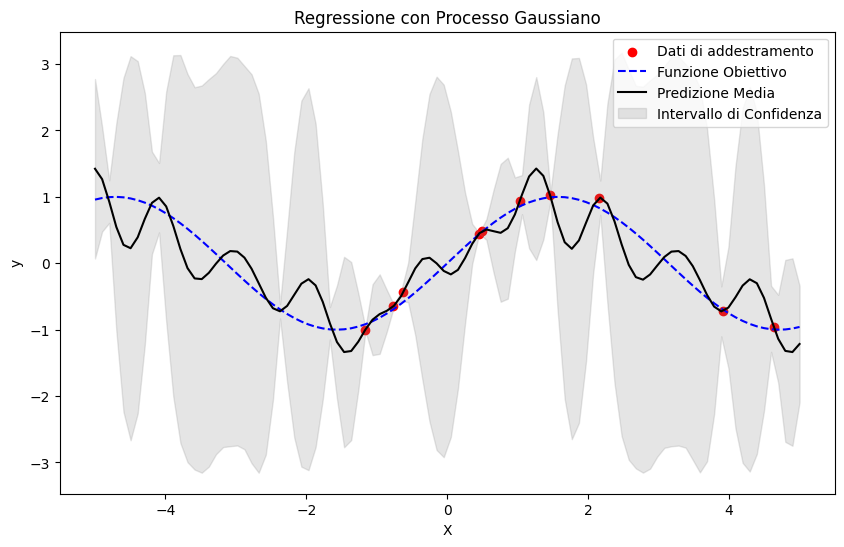

In [20]:
import numpy as np

# Definisci la funzione obiettivo
def funzione_obiettivo(x):
    return np.sin(x)

# Genera dati di addestramento
np.random.seed(0)

n_train = 10

X_train = np.random.uniform(-5, 5, size=(n_train, 1))
y_train = funzione_obiettivo(X_train) + np.random.normal(0, 0.1, size=(n_train, 1))

# Definisci il kernel (covarianza)
def kernel(x1, x2, l=1.0, sigma_f=1.0):
    sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

def dirichlet(x1, x2, n=8):
    d1 = x1.shape[0]
    d2 = x2.shape[0]

    mat = np.zeros((d1,d2))
    for i in range(d1):
        for j in range(d2):
            if x1[i]-x2[j]==0:
                mat[i,j] = n+0.5
            else:
                mat[i,j] = np.sin((n+0.5)*(x1[i]-x2[j]))/np.sin(x1[i]-x2[j])

    return mat

def werner(x1, x2, n=8):
    d1 = x1.shape[0]
    d2 = x2.shape[0]

    mat = np.zeros((d1,d2))
    for i in range(d1):
        for j in range(d2):
            if x1[i]-x2[j]==0:
                mat[i,j] = 1 + n
            else:
                mat[i,j] = 1 + np.sin(n*(x1[i]-x2[j])/2)/np.sin((x1[i]-x2[j])/2)*np.cos((n+1)*(x1[i]-x2[j])/2)
    
    return mat


# Definisci il modello di regressione con processo gaussiano
class GaussianProcessRegressor:
    def __init__(self, kernel, sigma_y=1e-8):
        self.kernel = kernel
        self.sigma_y = sigma_y

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.K = self.kernel(X, X)
        self.K += self.sigma_y**2 * np.eye(X.shape[0])
        self.L = np.linalg.cholesky(self.K)

    def predict(self, X_test):
        K_s = self.kernel(self.X_train, X_test)
        L_inv = np.linalg.solve(self.L, K_s)
        mu = np.dot(L_inv.T, np.linalg.solve(self.L, self.y_train))
        v = np.linalg.solve(self.L, K_s)
        var = self.kernel(X_test, X_test) - np.dot(L_inv.T, L_inv) + self.sigma_y**2
        return mu.flatten(), np.diagonal(var)

# Addestramento del modello
# gp = GaussianProcessRegressor(kernel=kernel, sigma_y=1e-6)
gp = GaussianProcessRegressor(kernel=werner, sigma_y=1e-6)
gp.fit(X_train, y_train)

# Genera dati di test
X_test = np.linspace(-5, 5, num=100).reshape(-1, 1)

# Fai previsioni con il modello addestrato
y_pred_mean, y_pred_var = gp.predict(X_test)

# Plot dei risultati
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, c='red', label='Dati di addestramento')
plt.plot(X_test, funzione_obiettivo(X_test), 'b--', label='Funzione Obiettivo')
plt.plot(X_test, y_pred_mean, 'k-', label='Predizione Media')
plt.fill_between(X_test.flatten(), y_pred_mean - np.sqrt(y_pred_var), y_pred_mean + np.sqrt(y_pred_var), color='gray', alpha=0.2, label='Intervallo di Confidenza')
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title('Regressione con Processo Gaussiano')
plt.show()